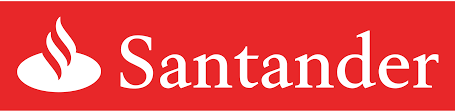

In [1]:
from IPython.display import Image
Image(filename='Santander logo.png', width=1200, height=100)

This is the Kaggle data compitition where Santander has provided its customer's demographics information, and which products customer's have bought which products in the past 17 months. Based on cutsomer's historical purchases, the objective of this competition is to predict which customer's will buy which product in the next month. 

So we have 22 features of customer and we have 24 products customer has bought in these 17 months. We will be predicting for each customer 7 most likely products and the model's accuracy will be measured on MAP@7

This is the final model which is only a short version after completing EDA and several versions of models. 

In [1]:
import csv
import datetime
import random
from operator import sub
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing, ensemble

Based on the prior analysis in EDA, I had decided to impute missing values as a separate category, which is coded as -99 here. I have created a dictionary for each variable so that mapping each variable to appropriate value is easier.

In [2]:
mapping_dict = {'ind_empleado'  : {-99:0, 'N':1, 'B':2, 'F':3, 'A':4, 'S':5},
'sexo'          : {'V':0, 'H':1, -99:2},
'ind_nuevo'     : {'0':0, '1':1, -99:1},
'indrel'        : {'1':0, '99':1, -99:1},
'indrel_1mes'   : {-99:0, '1.0':1, '1':1, '2.0':2, '2':2, '3.0':3, '3':3, '4.0':4, '4':4, 'P':5},
'tiprel_1mes'   : {-99:0, 'I':1, 'A':2, 'P':3, 'R':4, 'N':5},
'indresi'       : {-99:0, 'S':1, 'N':2},
'indext'        : {-99:0, 'S':1, 'N':2},
#'conyuemp'      : {-99:0, 'S':1, 'N':2},
'indfall'       : {-99:0, 'S':1, 'N':2},
#'tipodom'       : {-99:0, '1':1},
'ind_actividad_cliente' : {'0':0, '1':1, -99:2},
'segmento'      : {'02 - PARTICULARES':0, '03 - UNIVERSITARIO':1, '01 - TOP':2, -99:3},
'pais_residencia' : {'LV': 102, 'BE': 12, 'BG': 50, 'BA': 61, 'BM': 117, 'BO': 62, 'JP': 82, 'JM': 116, 'BR': 17, 'BY': 64, 'BZ': 113, 'RU': 43, 'RS': 89, 'RO': 41, 'GW': 99, 'GT': 44, 'GR': 39, 'GQ': 73, 'GE': 78, 'GB': 9, 'GA': 45, 'GN': 98, 'GM': 110, 'GI': 96, 'GH': 88, 'OM': 100, 'HR': 67, 'HU': 106, 'HK': 34, 'HN': 22, 'AD': 35, 'PR': 40, 'PT': 26, 'PY': 51, 'PA': 60, 'PE': 20, 'PK': 84, 'PH': 91, 'PL': 30, 'EE': 52, 'EG': 74, 'ZA': 75, 'EC': 19, 'AL': 25, 'VN': 90, 'ET': 54, 'ZW': 114, 'ES': 0, 'MD': 68, 'UY': 77, 'MM': 94, 'ML': 104, 'US': 15, 'MT': 118, 'MR': 48, 'UA': 49, 'MX': 16, 'IL': 42, 'FR': 8, 'MA': 38, 'FI': 23, 'NI': 33, 'NL': 7, 'NO': 46, 'NG': 83, 'NZ': 93, 'CI': 57, 'CH': 3, 'CO': 21, 'CN': 28, 'CM': 55, 'CL': 4, 'CA': 2, 'CG': 101, 'CF': 109, 'CD': 112, 'CZ': 36, 'CR': 32, 'CU': 72, 'KE': 65, 'KH': 95, 'SV': 53, 'SK': 69, 'KR': 87, 'KW': 92, 'SN': 47, 'SL': 97, 'KZ': 111, 'SA': 56, 'SG': 66, 'SE': 24, 'DO': 11, 'DJ': 115, 'DK': 76, 'DE': 10, 'DZ': 80, 'MK': 105, -99: 1, 'LB': 81, 'TW': 29, 'TR': 70, 'TN': 85, 'LT': 103, 'LU': 59, 'TH': 79, 'TG': 86, 'LY': 108, 'AE': 37, 'VE': 14, 'IS': 107, 'IT': 18, 'AO': 71, 'AR': 13, 'AU': 63, 'AT': 6, 'IN': 31, 'IE': 5, 'QA': 58, 'MZ': 27},
'canal_entrada' : {'013': 49, 'KHP': 160, 'KHQ': 157, 'KHR': 161, 'KHS': 162, 'KHK': 10, 'KHL': 0, 'KHM': 12, 'KHN': 21, 'KHO': 13, 'KHA': 22, 'KHC': 9, 'KHD': 2, 'KHE': 1, 'KHF': 19, '025': 159, 'KAC': 57, 'KAB': 28, 'KAA': 39, 'KAG': 26, 'KAF': 23, 'KAE': 30, 'KAD': 16, 'KAK': 51, 'KAJ': 41, 'KAI': 35, 'KAH': 31, 'KAO': 94, 'KAN': 110, 'KAM': 107, 'KAL': 74, 'KAS': 70, 'KAR': 32, 'KAQ': 37, 'KAP': 46, 'KAW': 76, 'KAV': 139, 'KAU': 142, 'KAT': 5, 'KAZ': 7, 'KAY': 54, 'KBJ': 133, 'KBH': 90, 'KBN': 122, 'KBO': 64, 'KBL': 88, 'KBM': 135, 'KBB': 131, 'KBF': 102, 'KBG': 17, 'KBD': 109, 'KBE': 119, 'KBZ': 67, 'KBX': 116, 'KBY': 111, 'KBR': 101, 'KBS': 118, 'KBP': 121, 'KBQ': 62, 'KBV': 100, 'KBW': 114, 'KBU': 55, 'KCE': 86, 'KCD': 85, 'KCG': 59, 'KCF': 105, 'KCA': 73, 'KCC': 29, 'KCB': 78, 'KCM': 82, 'KCL': 53, 'KCO': 104, 'KCN': 81, 'KCI': 65, 'KCH': 84, 'KCK': 52, 'KCJ': 156, 'KCU': 115, 'KCT': 112, 'KCV': 106, 'KCQ': 154, 'KCP': 129, 'KCS': 77, 'KCR': 153, 'KCX': 120, 'RED': 8, 'KDL': 158, 'KDM': 130, 'KDN': 151, 'KDO': 60, 'KDH': 14, 'KDI': 150, 'KDD': 113, 'KDE': 47, 'KDF': 127, 'KDG': 126, 'KDA': 63, 'KDB': 117, 'KDC': 75, 'KDX': 69, 'KDY': 61, 'KDZ': 99, 'KDT': 58, 'KDU': 79, 'KDV': 91, 'KDW': 132, 'KDP': 103, 'KDQ': 80, 'KDR': 56, 'KDS': 124, 'K00': 50, 'KEO': 96, 'KEN': 137, 'KEM': 155, 'KEL': 125, 'KEK': 145, 'KEJ': 95, 'KEI': 97, 'KEH': 15, 'KEG': 136, 'KEF': 128, 'KEE': 152, 'KED': 143, 'KEC': 66, 'KEB': 123, 'KEA': 89, 'KEZ': 108, 'KEY': 93, 'KEW': 98, 'KEV': 87, 'KEU': 72, 'KES': 68, 'KEQ': 138, -99: 6, 'KFV': 48, 'KFT': 92, 'KFU': 36, 'KFR': 144, 'KFS': 38, 'KFP': 40, 'KFF': 45, 'KFG': 27, 'KFD': 25, 'KFE': 148, 'KFB': 146, 'KFC': 4, 'KFA': 3, 'KFN': 42, 'KFL': 34, 'KFM': 141, 'KFJ': 33, 'KFK': 20, 'KFH': 140, 'KFI': 134, '007': 71, '004': 83, 'KGU': 149, 'KGW': 147, 'KGV': 43, 'KGY': 44, 'KGX': 24, 'KGC': 18, 'KGN': 11}
}
cat_cols = list(mapping_dict.keys())

#This is a list of target columns (22 out of 24, as 2 products are not used at all in Jun 2016)

In [3]:
target_cols = ['ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1','ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1','ind_deme_fin_ult1','ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1','ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1','ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']
target_cols = target_cols[2:]

In [4]:
#This function is to fetch a single row from the dataset and return target columns in a list
def getTarget(row):
    tlist = []
    for col in target_cols:
        if row[col].strip() in ['', 'NA']:
            target = 0
        else:
            target = int(float(row[col]))
        tlist.append(target)
    return tlist

In [5]:
#This function encodes the values from the mapping dictionary created above
def getIndex(row, col):
    val = row[col].strip()
    if val not in ['','NA']:
        ind = mapping_dict[col][val]
    else:
        ind = mapping_dict[col][-99]
    return ind

In [6]:
#We have age distribution from 0 to 164 in the data. Considering humans do live upto 100 years, I am impute 
#missing value to be the mean age(40) and standarize the age variable

def getAge(row):
    mean_age = 40.
    min_age = 0.
    max_age = 100.
    range_age = max_age - min_age
    age = row['age'].strip()
    if age == 'NA' or age == '':
        age = mean_age
    else:
        age = float(age)
        if age < min_age:
            age = min_age
        elif age > max_age:
            age = max_age
    return round( (age - min_age) / range_age, 4)

In [7]:
# We have a variable called CustomerSeniority which has values ranging from 0 to 256. This function imputes missing values
#to be 0 and then standardize the variable

def getCustSeniority(row):
    min_value = 0.
    max_value = 256.
    range_value = max_value - min_value
    missing_value = 0.
    cust_seniority = row['antiguedad'].strip()
    if cust_seniority == 'NA' or cust_seniority == '':
        cust_seniority = missing_value
    else:
        cust_seniority = float(cust_seniority)
        if cust_seniority < min_value:
            cust_seniority = min_value
        elif cust_seniority > max_value:
            cust_seniority = max_value
    return round((cust_seniority-min_value) / range_value, 4)

In [8]:
# I have tried various methods for imputing the houshold income, and this method gave me better results
# This function takes the median household income based on city and imputes missing household income as median 
# household income of all data and then standardise the household income

def getRent(row):
    min_value = 0.
    max_value = 1354778.
    range_value = max_value - min_value
    renta_dict = {'ALAVA': 96967,
 'ALBACETE': 78657,
 'ALICANTE': 67526,
 'ALMERIA': 73390,
 'ASTURIAS': 87199,
 'AVILA': 68561,
 'BADAJOZ': 62330,
 'BALEARS, ILLES': 123573,
 'BARCELONA': 131214,
 'BIZKAIA': 99978,
 'BURGOS': 89385,
 'CACERES': 67799,
 'CADIZ': 79016,
 'CANTABRIA': 95517,
 'CASTELLON': 66630,
 'CEUTA': 128699,
 'CIUDAD REAL': 62193,
 'CORDOBA': 69106,
 'CORUÑA, A': 97689,
 'CUENCA': 67201,
 'GIPUZKOA': 80599,
 'GIRONA': 108963,
 'GRANADA': 82447,
 'GUADALAJARA': 92724,
 'HUELVA': 68994,
 'HUESCA': 73467,
 'JAEN': 67886,
 'LEON': 80901,
 'LERIDA': 64818,
 'LUGO': 64390,
 'MADRID': 139070,
 'MALAGA': 95102,
 'MELILLA': 117408,
 'MURCIA': 67813,
 'NAVARRA': 86649,
 'OURENSE': 79069,
 'PALENCIA': 86593,
 'PALMAS, LAS': 80948,
 'PONTEVEDRA': 97829,
 'RIOJA, LA': 89936,
 'SALAMANCA': 89831,
 'SANTA CRUZ DE TENERIFE': 82729,
 'SEGOVIA': 89311,
 'SEVILLA': 92710,
 'SORIA': 78810,
 'TARRAGONA': 88283,
 'TERUEL': 76467,
 'TOLEDO': 68867,
 'UNKNOWN':101850,
 'VALENCIA': 72988,
 'VALLADOLID': 92880,
 'ZAMORA': 74692,
 'ZARAGOZA': 99950}

    #missing_value = 101850.
    rent = row['renta'].strip()
    if rent == 'NA' or rent == '':
        if row['nomprov'] == 'NA' or row['nomprov'] == '':
            rent = float(renta_dict['UNKNOWN'])
        else:
            rent = float(renta_dict[row['nomprov']])
    else:
        rent = float(rent)
        if rent < min_value:
            rent = min_value
        elif rent > max_value:
            rent = max_value

    return round((rent-min_value) / range_value, 6)



In [9]:
# Married flag - Based on department of Staistics spanish report, I tried creating married flag. But that method 
# did not work very well. So calculated married flag based on general knowledge. 
# This is not very predictive though.

def getMarriageIndex(row, age, sex, income):    
    if age <= 25:
        return 0
    else:
        return 1

In [10]:
# Since there is a high difference in number of customer joining by month, I decided to calculate the month. 
# This function returns the joining month.

def getjoinMonth(row):
    if row['fecha_alta'].strip() == 'NA' or row['fecha_alta'].strip() == '':
        return int(random.choice([1,2,3,4,5,6,7,8,9,10,11,12]))
    else:
        return int(row['fecha_alta'].split('-')[1])

In [11]:
# This is a very important function which does a lot of things:
# I have used train data to be Jun 2015 and test data to be Jun 2016. This is because there is severe change in number
# of products being bought per month. 
# 1. It calculates the new products bought for 2015(train data)
# 2. It calculates the lags for each product for train and test data.
# 3. Applied all the transformations mentioned above in all functions 
# 4. Create a final dataset which is passed on to XGB for predictions

def processData(in_file_name, cust_dict, lag_cust_dict,lag_cust_dict1,lag_cust_dict2,lag_cust_dict3,lag_cust_dict4):
    x_vars_list = []
    y_vars_list = []
    
    for row in csv.DictReader(in_file_name):
        #Use only 6 months
        if row['fecha_dato'] not in ['2015-01-28','2015-02-28','2015-03-28','2015-04-28', '2015-05-28', '2015-06-28', '2016-01-28','2016-02-28','2016-03-28','2016-04-28', '2016-05-28', '2016-06-28']:
            continue

        cust_id = int(row['ncodpers'])
        #print(row['fecha_dato'])
        if (row['fecha_dato'] in ['2015-01-28', '2016-01-28'] ):
            target_list = getTarget(row)
            lag_cust_dict4[cust_id] =  target_list[:]
            continue
            
        if (row['fecha_dato'] in ['2015-02-28', '2016-02-28'] ):
            target_list = getTarget(row)
            lag_cust_dict3[cust_id] =  target_list[:]
            continue
            
        if (row['fecha_dato'] in ['2015-03-28', '2016-03-28'] ):
            target_list = getTarget(row)
            lag_cust_dict2[cust_id] =  target_list[:]
            continue
            
        if (row['fecha_dato'] in ['2015-04-28', '2016-04-28'] ):
            target_list = getTarget(row)
            lag_cust_dict1[cust_id] =  target_list[:]
            continue
        
        if (row['fecha_dato'] in ['2015-05-28', '2016-05-28'] ):
            target_list = getTarget(row)
            cust_dict[cust_id] =  target_list[:]
            continue
        
        x_vars = []
        for col in cat_cols:
            x_vars.append( getIndex(row, col) )
        sex = getIndex(row, 'sexo')
        age = getAge(row)
        x_vars.append(age)
        #x_vars.append( getMonth(row))
        x_vars.append( getjoinMonth(row))
        x_vars.append(getCustSeniority(row))
        income = getRent(row)
        x_vars.append(income)
        x_vars.append(getMarriageIndex(row, age, sex, income) )
        if row['fecha_dato'] == '2016-06-28':
            prev_target_list = cust_dict.get(cust_id, [0]*22)
            lag_target_list = lag_cust_dict.get(cust_id, [0]*22)
            lag_target_list1 = lag_cust_dict1.get(cust_id, [0]*22)
            lag_target_list2 = lag_cust_dict2.get(cust_id, [0]*22)
            lag_target_list3 = lag_cust_dict3.get(cust_id, [0]*22)
            lag_target_list4 = lag_cust_dict4.get(cust_id, [0]*22)
            x_vars_list.append(x_vars + prev_target_list + lag_target_list+lag_target_list1+lag_target_list2+lag_target_list3+lag_target_list4)
        elif row['fecha_dato'] == '2015-06-28':
            prev_target_list = cust_dict.get(cust_id, [0]*22)
            lag_target_list = lag_cust_dict.get(cust_id, [0]*22)
            lag_target_list1 = lag_cust_dict1.get(cust_id, [0]*22)
            lag_target_list2 = lag_cust_dict2.get(cust_id, [0]*22)
            lag_target_list3 = lag_cust_dict3.get(cust_id, [0]*22)
            lag_target_list4 = lag_cust_dict4.get(cust_id, [0]*22)
            target_list = getTarget(row)
            new_products = [max(x1 - x2,0) for (x1, x2) in zip(target_list, prev_target_list)]
            if sum(new_products) > 0:
                for ind, prod in enumerate(new_products):
                    if prod>0:
                        assert len(prev_target_list) == 22
                        x_vars_list.append(x_vars+prev_target_list+lag_target_list+lag_target_list1+lag_target_list2+lag_target_list3+lag_target_list4)
                        y_vars_list.append(ind)        
        
    return x_vars_list, y_vars_list, cust_dict, lag_cust_dict, lag_cust_dict1, lag_cust_dict2,lag_cust_dict3,lag_cust_dict4 

In [17]:
def runXGB(train_X, train_y, seed_val=25):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.08
    param['max_depth'] = 7
    param['silent'] = 1
    param['num_class'] = 22
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.9
    param['colsample_bytree'] = 0.9
    param['seed'] = seed_val
    param['gamma'] = 0.15 
    param['reg-alpha']=0.075
    num_rounds = 100

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    model = xgb.train(plst, xgtrain, num_rounds)	
    return model

In [13]:
if __name__ == "__main__":
    start_time = datetime.datetime.now()
    data_path = "../Capstone Project/Raw data/"
    train_file =  open(data_path + "train_ver2.csv")
    print('Starting file processing')
    #x_vars_list, y_vars_list, cust_dict = processData(train_file, {})
    x_vars_list, y_vars_list, cust_dict, lag_cust_dict,lag_cust_dict1,lag_cust_dict2,lag_cust_dict3,lag_cust_dict4 = processData(train_file, {}, {},{},{},{},{})
    print('Finished file processing')
    train_X = np.array(x_vars_list)
    train_y = np.array(y_vars_list)
    print(np.unique(train_y))
    del x_vars_list, y_vars_list
    train_file.close()
    print(train_X.shape, train_y.shape)
    print(datetime.datetime.now()-start_time)
    test_file = open(data_path + "test_ver2.csv")
    x_vars_list, y_vars_list, cust_dict, lag_cust_dict,lag_cust_dict1,lag_cust_dict2,lag_cust_dict3,lag_cust_dict4 = processData(test_file, cust_dict, lag_cust_dict,lag_cust_dict1,lag_cust_dict2,lag_cust_dict3,lag_cust_dict4)
    test_X = np.array(x_vars_list)
    del x_vars_list
    test_file.close()
    print(test_X.shape)
    print(datetime.datetime.now()-start_time)

Starting file processing
Finished file processing
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
((45679, 150), (45679,))
0:06:21.616381
(929615, 150)
0:07:15.927837


In [14]:
#Parameter Tunning

In [15]:
# Parameter tunning in Xtreme gradient Boosting

import sys
import math
 
import numpy as np
from sklearn.grid_search import GridSearchCV
 
#sys.path.append('xgboost/wrapper/')
import xgboost as xgb
 
class XGBoostClassifier():
    def __init__(self, num_boost_round=10, **params):
        self.clf = None
        self.num_boost_round = num_boost_round
        self.params = params
        self.params.update({'objective': 'multi:softprob'})
 
    def fit(self, X, y, num_boost_round=None):
        num_boost_round = num_boost_round or self.num_boost_round
        self.label2num = dict((label, i) for i, label in enumerate(sorted(set(y))))
        dtrain = xgb.DMatrix(X, label=[self.label2num[label] for label in y])
        self.clf = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=num_boost_round)
 
    def predict(self, X):
        num2label = dict((i, label)for label, i in self.label2num.items())
        Y = self.predict_proba(X)
        y = np.argmax(Y, axis=1)
        return np.array([num2label[i] for i in y])
 
    def predict_proba(self, X):
        dtest = xgb.DMatrix(X)
        return self.clf.predict(dtest)
 
    def score(self, X, y):
        Y = self.predict_proba(X)
        return 1 / logloss(y, Y)
 
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        if 'objective' in params:
            del params['objective']
        self.params.update(params)
        return self
    
    
def logloss(y_true, Y_pred):
    label2num = dict((name, i) for i, name in enumerate(sorted(set(y_true))))
    return -1 * sum(math.log(y[label2num[label]]) if y[label2num[label]] > 0 else -np.inf for y, label in zip(Y_pred, y_true)) / len(Y_pred)


def main():
    clf = XGBoostClassifier(
        eval_metric = 'logloss',
        num_class = 22,
        nthread = 4,
        eta = 0.07,
        num_boost_round = 10,
        max_depth = 9,
        min_child_weight = 1,
        subsample = 0.85,
        colsample_bytree = 0.8,
        silent = 1,
        reg_alpha=0.07,
        gamma = 0.9
        )
    parameters = {
        'gamma':[0.6, 0.7,0.8,0.9,1]
        #'num_boost_round': [50, 100, 150],
        #'eta': [0.06,0.065,0.07],
        #'reg_alpha':[0.067,0.07, 0.072,0.075]
        #'max_depth': [7,8,9],
        #'min_child_weight':[1,2,3]
        #'subsample': [0.9, 0.8, 0.85, 0.95],
        #'colsample_bytree': [0.8,0.85, 0.9, 0.95],
    }
    clf = GridSearchCV(clf, parameters, n_jobs=1, cv=2)
    print("Fitting the model")
    clf.fit(train_X,train_y)
    print("Training model completed")
    best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
    print(score)
    for param_name in sorted(best_parameters.keys()):
        print("%s: %r" % (param_name, best_parameters[param_name]))
                
    print(clf.predict(test_X))


if __name__ == '__main__':
    start_time=datetime.datetime.now()
    main()
    print(datetime.datetime.now()-start_time)

Fitting the model


/Users/ipm/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ipm/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Training model completed
0.357642313397
gamma: 0.8
[21 21 21 ..., 21 21  0]
0:02:31.768834


In [18]:
print("Building model..")
model = runXGB(train_X, train_y, seed_val=0)
print("Predicting..")
xgtest = xgb.DMatrix(test_X)
preds = model.predict(xgtest)

Building model..
Predicting..


In [19]:
print("Getting the top products..")
test_id = np.array(pd.read_csv(data_path + "test_ver2.csv", usecols=['ncodpers'])['ncodpers'])
new_products = []
for i, idx in enumerate(test_id):
    new_products.append([max(x1 - x2,0) for (x1, x2) in zip(preds[i,:], cust_dict[idx])])
target_cols = np.array(target_cols)
preds = np.argsort(np.array(new_products), axis=1)

Getting the top products..


In [20]:
#DROP product 7,8,9,12,18 as theese items have not been purchased /not popular in recent months. 
l1 = []
for i,item in enumerate(preds):
    l1.append(filter(lambda x: x not in (7,8,9,12,18),preds[i,:]))
new_pred = np.asarray(l1)
new_pred = np.fliplr(new_pred)[:,:7]
final_preds = [" ".join(list(target_cols[pred])) for pred in new_pred]
out_df = pd.DataFrame({'ncodpers':test_id, 'added_products':final_preds})
out_df.to_csv('submission28.csv', index=False)

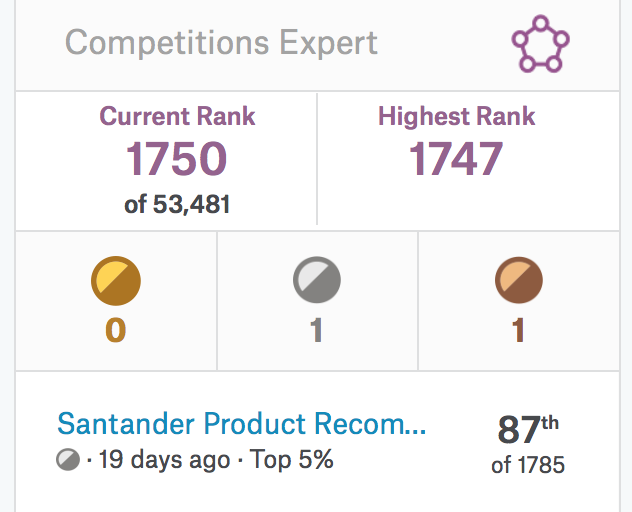

In [8]:
#Model results can be seen here:
from IPython.display import Image
Image(filename='Kaggle Rank.png', width=800, height=10)